In [1]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import rtree
import geopandas
import xarray as xr
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import h3
import base64
import urllib
import tempfile
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

In [2]:
temp_data = xr.open_rasterio(
    r"./data/生态文明指数1.tif")
temp_data.attrs['crs'] = 'EPSG:4326'
df = temp_data.sel(band=1).to_pandas().stack().reset_index().rename(
  columns={'x': 'lng', 'y': 'lat', 0: 'value'})
df


,lat,lng,value
0,28.64894,115.639718,-3.402823e+38
1,28.64894,115.641866,-3.402823e+38
2,28.64894,115.644015,-3.402823e+38
3,28.64894,115.646164,-3.402823e+38
4,28.64894,115.648313,-3.402823e+38
...,...,...,...
6216667,23.16737,120.863433,-3.402823e+38
6216668,23.16737,120.865581,-3.402823e+38
6216669,23.16737,120.867730,-3.402823e+38
6216670,23.16737,120.869879,-3.402823e+38


In [3]:
temp_df = df[df.value > -1000]
temp_df

,lat,lng,value
383880,28.311580,118.708194,0.767734
383881,28.311580,118.710342,0.787997
386312,28.309431,118.699598,0.739093
386314,28.309431,118.703896,0.771629
386315,28.309431,118.706045,0.770707
...,...,...,...
5742467,23.584236,117.390984,0.687273
5742468,23.584236,117.393132,0.681006
5742469,23.584236,117.395281,0.657463
5744878,23.582087,117.337264,0.716746


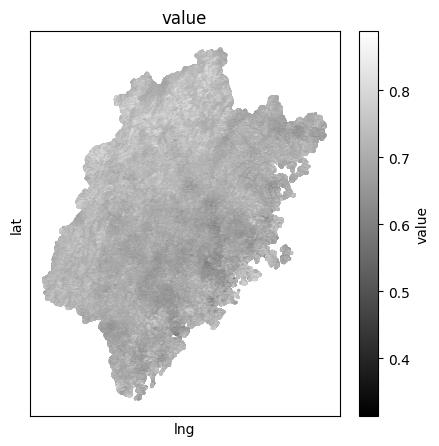

In [4]:
# Visualize the elevation
plot_scatter(temp_df, metric_col='value', marker='.',
             colormap='gray', figsize=(5, 5))


In [9]:
APERTURE_SIZE = 5
hex_col = 'hex'

# find hexs containing the points
temp_df[hex_col] = temp_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, APERTURE_SIZE), 1)

# calculate elevation average per hex
df_dem = temp_df.groupby(hex_col)['value'].mean().to_frame(
    'value').reset_index()

#find center of hex for visualization
df_dem['lat'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_dem['lng'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# plot the hexes



TypeError: title() missing 1 required positional argument: 'label'

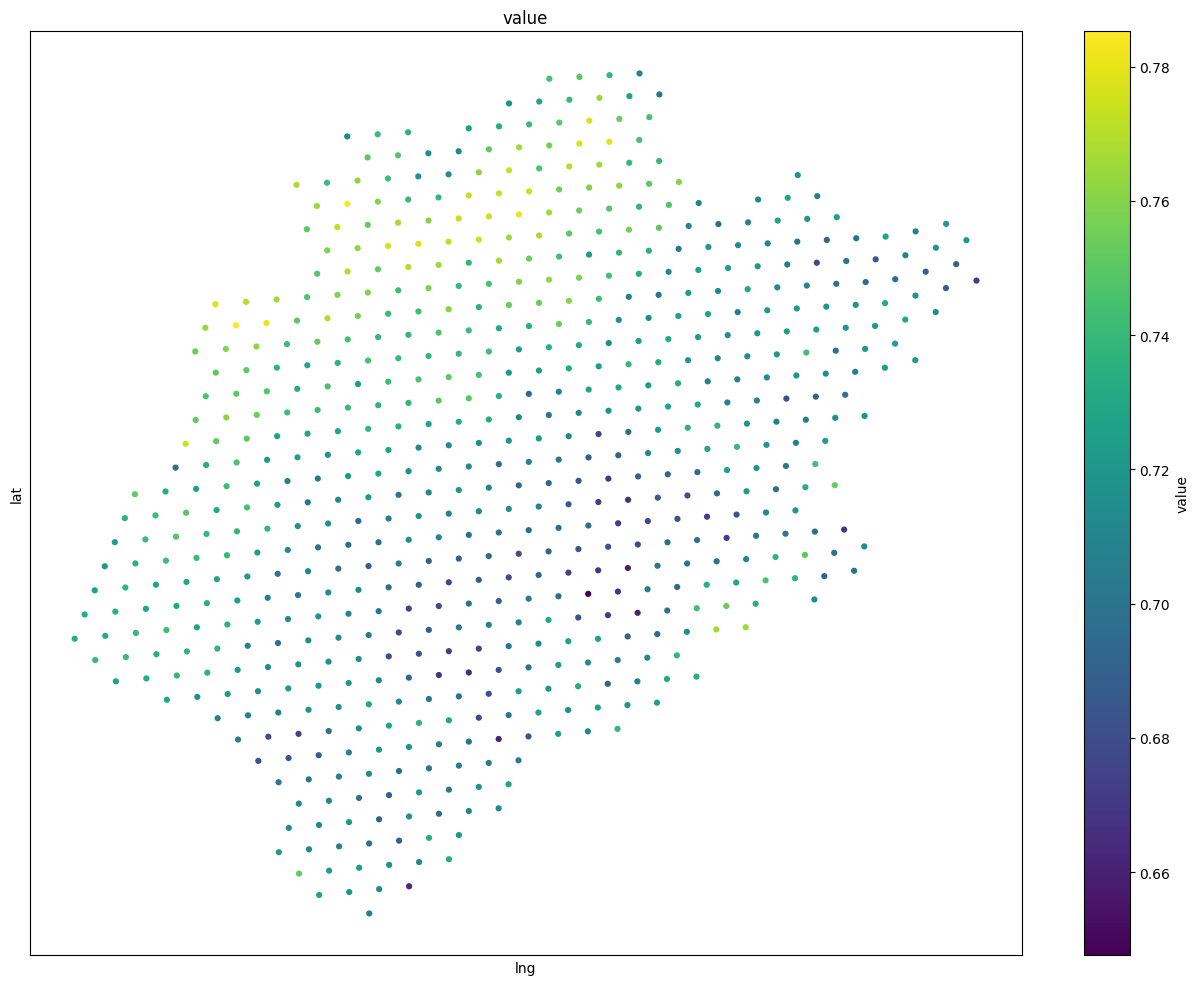

In [10]:
# plot_scatter(df_dem, metric_col='value', marker='o', figsize=(5, 5))
# plt.title('福建省生态文明指数')

plot_scatter(df_dem, metric_col='value', marker='o')
plt.title('福建省生态文明指数')


In [76]:
from shapely.geometry import Polygon
import json

geojson_out = {
    "type": "FeatureCollection",
    "features": []
}

for i in range(len(df_dem)):
    geojson_out["features"].append({
        "type": "Feature",
        "properties": {
            "identifier": i
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                h3.h3_to_geo_boundary(df_dem['hex'][i], geo_json=True)
            ]
        },
        'properties': {
            "value": float(df_dem['value'][i]),
        }
    })

# geojson_out
with open("./福建省result/福建省净碳排放1.json", "w", encoding='utf-8') as outfile:
    json.dump(geojson_out, outfile, ensure_ascii=False, indent=4)
